# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=80  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=256, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=256, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, int(out_planes*0.125), kernel_size=1, stride=1, padding=0, bias=True)
        
        #------------------------ 另一半 ----------------------------
        self.scaleLayer= nn.Conv1d(1, 1, 1, stride=1,padding=0,groups=1,dilation=1,bias=True)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, int(out_planes*0.875), one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=True) # 在__init__初始化        
        
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu6(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        #w=w[0]-torch.mean(w[0])
        w=torch.randn(w[0].shape).cuda()*1
        
        a=torch.randn(1).cuda()*0.1
        if a>0.37:
            print(w.shape)
            print(w)
        
        w=w.view(1,1,in_channel)
        w=self.scaleLayer(w)
        if a>0.37:
            print(self.scaleLayer.weight)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        
        #-------------------------------------
        #w = 0.1*F.tanh(w) # [-0.5,+0.5]
        w=F.softmax(w,dim=2)
        
        if a>0.37:
            print(w.shape)
            print(w)
            
        # [bs=1,out_channel//2,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel//2,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out_1=self.conv2(out)
        out_2=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)
        out=torch.cat([out_1,out_2],1)
        
        # ----------------------- 试一试不要用relu -------------------------------
        out = F.relu6(self.bn2(out))
        
        return out

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, [512,1], [512,1],[512,1], [512,1], [1024,1], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,70,75,80], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.321921, Accuracy: 13.28
Train Epoch: 0 [1280/50000 (3%)]	Loss: 2.697963, Accuracy: 12.50
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.295963, Accuracy: 13.67
Train Epoch: 0 [3840/50000 (9%)]	Loss: 2.228629, Accuracy: 11.72
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.152878, Accuracy: 16.80
Train Epoch: 0 [6400/50000 (14%)]	Loss: 2.250362, Accuracy: 14.84
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.094981, Accuracy: 17.97
Train Epoch: 0 [8960/50000 (20%)]	Loss: 2.055869, Accuracy: 21.09
Train Epoch: 0 [10240/50000 (23%)]	Loss: 2.010003, Accuracy: 23.44
Train Epoch: 0 [11520/50000 (26%)]	Loss: 1.964749, Accuracy: 20.70
Train Epoch: 0 [12800/50000 (28%)]	Loss: 2.021680, Accuracy: 23.83
Train Epoch: 0 [14080/50000 (31%)]	Loss: 1.959093, Accuracy: 21.48
Train Epoch: 0 [15360/50000 (34%)]	Loss: 1.864657, Accuracy: 22.27
Train Epoch: 0 [16640/50000 (37%)]	Loss: 1.942775, Accuracy: 23.05
Train Epoch: 0 [17920/50000 (40%)]	Loss: 1.841356, Accuracy: 23.83
Train Epoc

Train Epoch: 2 [35000/50000 (99%)]	Loss: 1.037163, Accuracy: 61.50

Validation set: Average loss: 1.2850, Accuracy: 2738/5000 (54.00%)

the time of this epoch:[37.23303699493408 s]
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.066273, Accuracy: 62.11
Train Epoch: 3 [1280/50000 (3%)]	Loss: 1.035068, Accuracy: 62.50
Train Epoch: 3 [2560/50000 (6%)]	Loss: 0.928706, Accuracy: 67.58
Train Epoch: 3 [3840/50000 (9%)]	Loss: 1.222573, Accuracy: 60.16
Train Epoch: 3 [5120/50000 (11%)]	Loss: 1.064418, Accuracy: 65.23
Train Epoch: 3 [6400/50000 (14%)]	Loss: 0.974463, Accuracy: 67.19
Train Epoch: 3 [7680/50000 (17%)]	Loss: 0.996837, Accuracy: 66.80
Train Epoch: 3 [8960/50000 (20%)]	Loss: 0.949750, Accuracy: 69.53
Train Epoch: 3 [10240/50000 (23%)]	Loss: 1.016648, Accuracy: 63.28
Train Epoch: 3 [11520/50000 (26%)]	Loss: 1.085958, Accuracy: 61.72
Train Epoch: 3 [12800/50000 (28%)]	Loss: 0.962692, Accuracy: 64.84
Train Epoch: 3 [14080/50000 (31%)]	Loss: 1.002265, Accuracy: 63.67
Train Epoch: 3 [15360/50000 (3

Train Epoch: 5 [39680/50000 (88%)]	Loss: 0.667401, Accuracy: 78.12
Train Epoch: 5 [40960/50000 (91%)]	Loss: 0.755858, Accuracy: 73.83
Train Epoch: 5 [42240/50000 (94%)]	Loss: 0.686147, Accuracy: 75.39
Train Epoch: 5 [43520/50000 (97%)]	Loss: 0.749370, Accuracy: 73.44
Train Epoch: 5 [35000/50000 (99%)]	Loss: 0.817995, Accuracy: 72.00

Validation set: Average loss: 0.8467, Accuracy: 3485/5000 (69.00%)

the time of this epoch:[37.137524366378784 s]
Train Epoch: 6 [0/50000 (0%)]	Loss: 0.674195, Accuracy: 75.39
Train Epoch: 6 [1280/50000 (3%)]	Loss: 0.653373, Accuracy: 77.73
Train Epoch: 6 [2560/50000 (6%)]	Loss: 0.786067, Accuracy: 74.22
Train Epoch: 6 [3840/50000 (9%)]	Loss: 0.651057, Accuracy: 79.69
Train Epoch: 6 [5120/50000 (11%)]	Loss: 0.865275, Accuracy: 71.88
Train Epoch: 6 [6400/50000 (14%)]	Loss: 0.646114, Accuracy: 77.73
Train Epoch: 6 [7680/50000 (17%)]	Loss: 0.709238, Accuracy: 76.17
Train Epoch: 6 [8960/50000 (20%)]	Loss: 0.670643, Accuracy: 78.52
Train Epoch: 6 [10240/50000 (

Train Epoch: 9 [5120/50000 (11%)]	Loss: 0.605156, Accuracy: 77.34
Train Epoch: 9 [6400/50000 (14%)]	Loss: 0.582304, Accuracy: 78.52
Train Epoch: 9 [7680/50000 (17%)]	Loss: 0.546707, Accuracy: 78.91
Train Epoch: 9 [8960/50000 (20%)]	Loss: 0.652473, Accuracy: 77.73
Train Epoch: 9 [10240/50000 (23%)]	Loss: 0.666497, Accuracy: 78.12
Train Epoch: 9 [11520/50000 (26%)]	Loss: 0.583656, Accuracy: 78.91
Train Epoch: 9 [12800/50000 (28%)]	Loss: 0.655082, Accuracy: 78.91
Train Epoch: 9 [14080/50000 (31%)]	Loss: 0.556977, Accuracy: 81.25
Train Epoch: 9 [15360/50000 (34%)]	Loss: 0.603689, Accuracy: 79.69
Train Epoch: 9 [16640/50000 (37%)]	Loss: 0.662443, Accuracy: 80.08
Train Epoch: 9 [17920/50000 (40%)]	Loss: 0.624766, Accuracy: 77.34
Train Epoch: 9 [19200/50000 (43%)]	Loss: 0.509140, Accuracy: 80.47
Train Epoch: 9 [20480/50000 (45%)]	Loss: 0.600016, Accuracy: 79.69
Train Epoch: 9 [21760/50000 (48%)]	Loss: 0.609634, Accuracy: 78.91
Train Epoch: 9 [23040/50000 (51%)]	Loss: 0.531410, Accuracy: 82.81

Train Epoch: 12 [15360/50000 (34%)]	Loss: 0.463897, Accuracy: 81.25
Train Epoch: 12 [16640/50000 (37%)]	Loss: 0.530624, Accuracy: 82.03
Train Epoch: 12 [17920/50000 (40%)]	Loss: 0.525829, Accuracy: 80.86
Train Epoch: 12 [19200/50000 (43%)]	Loss: 0.556878, Accuracy: 82.03
Train Epoch: 12 [20480/50000 (45%)]	Loss: 0.492058, Accuracy: 81.64
Train Epoch: 12 [21760/50000 (48%)]	Loss: 0.554443, Accuracy: 82.03
Train Epoch: 12 [23040/50000 (51%)]	Loss: 0.437036, Accuracy: 86.33
Train Epoch: 12 [24320/50000 (54%)]	Loss: 0.525989, Accuracy: 80.86
Train Epoch: 12 [25600/50000 (57%)]	Loss: 0.603295, Accuracy: 81.25
Train Epoch: 12 [26880/50000 (60%)]	Loss: 0.594421, Accuracy: 82.81
torch.Size([512, 1, 1])
tensor([[[ 1.0249e+00]],

        [[ 2.4982e-01]],

        [[ 6.7892e-01]],

        [[ 2.0729e+00]],

        [[ 3.4217e-02]],

        [[-1.5033e+00]],

        [[-2.3495e-01]],

        [[-2.1329e-01]],

        [[-8.8490e-01]],

        [[-5.0810e-01]],

        [[-1.5447e+00]],

        [[

Train Epoch: 12 [28160/50000 (62%)]	Loss: 0.617025, Accuracy: 78.52
Train Epoch: 12 [29440/50000 (65%)]	Loss: 0.539521, Accuracy: 82.03
Train Epoch: 12 [30720/50000 (68%)]	Loss: 0.461722, Accuracy: 83.98
Train Epoch: 12 [32000/50000 (71%)]	Loss: 0.521079, Accuracy: 82.03
Train Epoch: 12 [33280/50000 (74%)]	Loss: 0.492417, Accuracy: 80.47
Train Epoch: 12 [34560/50000 (77%)]	Loss: 0.523238, Accuracy: 83.20
Train Epoch: 12 [35840/50000 (80%)]	Loss: 0.422706, Accuracy: 83.98
Train Epoch: 12 [37120/50000 (82%)]	Loss: 0.583637, Accuracy: 83.59
Train Epoch: 12 [38400/50000 (85%)]	Loss: 0.650664, Accuracy: 79.69
Train Epoch: 12 [39680/50000 (88%)]	Loss: 0.548782, Accuracy: 82.81
Train Epoch: 12 [40960/50000 (91%)]	Loss: 0.437934, Accuracy: 84.77
Train Epoch: 12 [42240/50000 (94%)]	Loss: 0.476372, Accuracy: 83.20
Train Epoch: 12 [43520/50000 (97%)]	Loss: 0.563801, Accuracy: 81.25
Train Epoch: 12 [35000/50000 (99%)]	Loss: 0.549606, Accuracy: 83.50

Validation set: Average loss: 1.1080, Accuracy:

Train Epoch: 15 [37120/50000 (82%)]	Loss: 0.350279, Accuracy: 88.28
Train Epoch: 15 [38400/50000 (85%)]	Loss: 0.460340, Accuracy: 84.77
Train Epoch: 15 [39680/50000 (88%)]	Loss: 0.520668, Accuracy: 82.81
Train Epoch: 15 [40960/50000 (91%)]	Loss: 0.440665, Accuracy: 85.55
Train Epoch: 15 [42240/50000 (94%)]	Loss: 0.482746, Accuracy: 84.38
Train Epoch: 15 [43520/50000 (97%)]	Loss: 0.546832, Accuracy: 80.86
Train Epoch: 15 [35000/50000 (99%)]	Loss: 0.558348, Accuracy: 80.50

Validation set: Average loss: 0.7722, Accuracy: 3683/5000 (73.00%)

the time of this epoch:[40.39142417907715 s]
Train Epoch: 16 [0/50000 (0%)]	Loss: 0.438759, Accuracy: 85.94
Train Epoch: 16 [1280/50000 (3%)]	Loss: 0.438488, Accuracy: 84.77
Train Epoch: 16 [2560/50000 (6%)]	Loss: 0.501893, Accuracy: 82.03
Train Epoch: 16 [3840/50000 (9%)]	Loss: 0.552238, Accuracy: 83.20
Train Epoch: 16 [5120/50000 (11%)]	Loss: 0.556648, Accuracy: 77.73
Train Epoch: 16 [6400/50000 (14%)]	Loss: 0.552949, Accuracy: 80.08
Train Epoch: 16


Test set: Average loss: 0.6559, Accuracy: 7829/10000 (78.29%)

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.326682, Accuracy: 89.84
Train Epoch: 19 [1280/50000 (3%)]	Loss: 0.505289, Accuracy: 82.81
Train Epoch: 19 [2560/50000 (6%)]	Loss: 0.393750, Accuracy: 87.11
Train Epoch: 19 [3840/50000 (9%)]	Loss: 0.438517, Accuracy: 82.81
Train Epoch: 19 [5120/50000 (11%)]	Loss: 0.402575, Accuracy: 86.33
Train Epoch: 19 [6400/50000 (14%)]	Loss: 0.405082, Accuracy: 86.72
Train Epoch: 19 [7680/50000 (17%)]	Loss: 0.457305, Accuracy: 84.38
Train Epoch: 19 [8960/50000 (20%)]	Loss: 0.479024, Accuracy: 85.16
Train Epoch: 19 [10240/50000 (23%)]	Loss: 0.526395, Accuracy: 84.38
Train Epoch: 19 [11520/50000 (26%)]	Loss: 0.376206, Accuracy: 87.50
Train Epoch: 19 [12800/50000 (28%)]	Loss: 0.448292, Accuracy: 84.77
Train Epoch: 19 [14080/50000 (31%)]	Loss: 0.451676, Accuracy: 85.55
Train Epoch: 19 [15360/50000 (34%)]	Loss: 0.487461, Accuracy: 84.38
Train Epoch: 19 [16640/50000 (37%)]	Loss: 0.513386, Accuracy: 82.42

Train Epoch: 20 [35840/50000 (80%)]	Loss: 0.437083, Accuracy: 85.55
Train Epoch: 20 [37120/50000 (82%)]	Loss: 0.501975, Accuracy: 81.25
Train Epoch: 20 [38400/50000 (85%)]	Loss: 0.511496, Accuracy: 82.03
Train Epoch: 20 [39680/50000 (88%)]	Loss: 0.480808, Accuracy: 82.42
Train Epoch: 20 [40960/50000 (91%)]	Loss: 0.447748, Accuracy: 85.55
Train Epoch: 20 [42240/50000 (94%)]	Loss: 0.421141, Accuracy: 87.50
Train Epoch: 20 [43520/50000 (97%)]	Loss: 0.455027, Accuracy: 85.55
Train Epoch: 20 [35000/50000 (99%)]	Loss: 0.411448, Accuracy: 86.00

Validation set: Average loss: 0.6929, Accuracy: 3879/5000 (77.00%)

the time of this epoch:[37.1706805229187 s]

Test set: Average loss: 0.7072, Accuracy: 7746/10000 (77.46%)

Train Epoch: 21 [0/50000 (0%)]	Loss: 0.395908, Accuracy: 87.89
Train Epoch: 21 [1280/50000 (3%)]	Loss: 0.406675, Accuracy: 85.94
Train Epoch: 21 [2560/50000 (6%)]	Loss: 0.356312, Accuracy: 87.89
Train Epoch: 21 [3840/50000 (9%)]	Loss: 0.429910, Accuracy: 83.59
Train Epoch: 21 [5

Train Epoch: 23 [35000/50000 (99%)]	Loss: 0.461930, Accuracy: 87.00

Validation set: Average loss: 0.6951, Accuracy: 3861/5000 (77.00%)

the time of this epoch:[40.302571058273315 s]
Train Epoch: 24 [0/50000 (0%)]	Loss: 0.481626, Accuracy: 83.20
Train Epoch: 24 [1280/50000 (3%)]	Loss: 0.409597, Accuracy: 85.94
Train Epoch: 24 [2560/50000 (6%)]	Loss: 0.551067, Accuracy: 82.81
Train Epoch: 24 [3840/50000 (9%)]	Loss: 0.499101, Accuracy: 83.59
Train Epoch: 24 [5120/50000 (11%)]	Loss: 0.421533, Accuracy: 83.59
Train Epoch: 24 [6400/50000 (14%)]	Loss: 0.492672, Accuracy: 84.77
Train Epoch: 24 [7680/50000 (17%)]	Loss: 0.402756, Accuracy: 85.94
Train Epoch: 24 [8960/50000 (20%)]	Loss: 0.445505, Accuracy: 88.67
Train Epoch: 24 [10240/50000 (23%)]	Loss: 0.449359, Accuracy: 85.16
Train Epoch: 24 [11520/50000 (26%)]	Loss: 0.400743, Accuracy: 85.94
Train Epoch: 24 [12800/50000 (28%)]	Loss: 0.333999, Accuracy: 89.06
Train Epoch: 24 [14080/50000 (31%)]	Loss: 0.377827, Accuracy: 87.89
Train Epoch: 24 

Train Epoch: 24 [30720/50000 (68%)]	Loss: 0.446593, Accuracy: 83.98
Train Epoch: 24 [32000/50000 (71%)]	Loss: 0.397583, Accuracy: 87.11
Train Epoch: 24 [33280/50000 (74%)]	Loss: 0.587445, Accuracy: 80.86
Train Epoch: 24 [34560/50000 (77%)]	Loss: 0.380614, Accuracy: 88.28
Train Epoch: 24 [35840/50000 (80%)]	Loss: 0.464266, Accuracy: 83.59
Train Epoch: 24 [37120/50000 (82%)]	Loss: 0.354633, Accuracy: 88.67
Train Epoch: 24 [38400/50000 (85%)]	Loss: 0.517249, Accuracy: 86.33
Train Epoch: 24 [39680/50000 (88%)]	Loss: 0.496121, Accuracy: 81.25
Train Epoch: 24 [40960/50000 (91%)]	Loss: 0.386531, Accuracy: 88.67
Train Epoch: 24 [42240/50000 (94%)]	Loss: 0.529417, Accuracy: 81.64
Train Epoch: 24 [43520/50000 (97%)]	Loss: 0.403443, Accuracy: 85.55
Train Epoch: 24 [35000/50000 (99%)]	Loss: 0.488615, Accuracy: 84.50

Validation set: Average loss: 0.5440, Accuracy: 4073/5000 (81.00%)

the time of this epoch:[37.15900182723999 s]

Test set: Average loss: 0.5418, Accuracy: 8202/10000 (82.02%)

Train 

Train Epoch: 25 [14080/50000 (31%)]	Loss: 0.444423, Accuracy: 83.59
Train Epoch: 25 [15360/50000 (34%)]	Loss: 0.328208, Accuracy: 91.41
Train Epoch: 25 [16640/50000 (37%)]	Loss: 0.380212, Accuracy: 85.16
Train Epoch: 25 [17920/50000 (40%)]	Loss: 0.436097, Accuracy: 85.55
Train Epoch: 25 [19200/50000 (43%)]	Loss: 0.434314, Accuracy: 85.16
Train Epoch: 25 [20480/50000 (45%)]	Loss: 0.399607, Accuracy: 84.77
Train Epoch: 25 [21760/50000 (48%)]	Loss: 0.414025, Accuracy: 86.33
Train Epoch: 25 [23040/50000 (51%)]	Loss: 0.451177, Accuracy: 83.20
Train Epoch: 25 [24320/50000 (54%)]	Loss: 0.420077, Accuracy: 85.94
Train Epoch: 25 [25600/50000 (57%)]	Loss: 0.414275, Accuracy: 87.89
Train Epoch: 25 [26880/50000 (60%)]	Loss: 0.460718, Accuracy: 84.38
Train Epoch: 25 [28160/50000 (62%)]	Loss: 0.542330, Accuracy: 78.91
Train Epoch: 25 [29440/50000 (65%)]	Loss: 0.476538, Accuracy: 83.98
Train Epoch: 25 [30720/50000 (68%)]	Loss: 0.512883, Accuracy: 83.20
Train Epoch: 25 [32000/50000 (71%)]	Loss: 0.4546

Train Epoch: 28 [24320/50000 (54%)]	Loss: 0.446890, Accuracy: 84.38
Train Epoch: 28 [25600/50000 (57%)]	Loss: 0.403022, Accuracy: 85.94
Train Epoch: 28 [26880/50000 (60%)]	Loss: 0.415364, Accuracy: 86.72
Train Epoch: 28 [28160/50000 (62%)]	Loss: 0.344020, Accuracy: 87.50
Train Epoch: 28 [29440/50000 (65%)]	Loss: 0.361206, Accuracy: 87.50
Train Epoch: 28 [30720/50000 (68%)]	Loss: 0.393067, Accuracy: 86.72
Train Epoch: 28 [32000/50000 (71%)]	Loss: 0.351325, Accuracy: 90.23
Train Epoch: 28 [33280/50000 (74%)]	Loss: 0.508907, Accuracy: 85.94
Train Epoch: 28 [34560/50000 (77%)]	Loss: 0.443267, Accuracy: 85.94
Train Epoch: 28 [35840/50000 (80%)]	Loss: 0.329446, Accuracy: 90.23
Train Epoch: 28 [37120/50000 (82%)]	Loss: 0.377736, Accuracy: 87.11
Train Epoch: 28 [38400/50000 (85%)]	Loss: 0.397143, Accuracy: 87.11
Train Epoch: 28 [39680/50000 (88%)]	Loss: 0.450829, Accuracy: 83.20
Train Epoch: 28 [40960/50000 (91%)]	Loss: 0.371886, Accuracy: 88.28
Train Epoch: 28 [42240/50000 (94%)]	Loss: 0.4770

Train Epoch: 31 [33280/50000 (74%)]	Loss: 0.498425, Accuracy: 82.81
Train Epoch: 31 [34560/50000 (77%)]	Loss: 0.367828, Accuracy: 87.50
Train Epoch: 31 [35840/50000 (80%)]	Loss: 0.450762, Accuracy: 83.98
Train Epoch: 31 [37120/50000 (82%)]	Loss: 0.455778, Accuracy: 85.16
Train Epoch: 31 [38400/50000 (85%)]	Loss: 0.478064, Accuracy: 83.59
Train Epoch: 31 [39680/50000 (88%)]	Loss: 0.426196, Accuracy: 85.55
Train Epoch: 31 [40960/50000 (91%)]	Loss: 0.342028, Accuracy: 88.67
Train Epoch: 31 [42240/50000 (94%)]	Loss: 0.344137, Accuracy: 87.11
Train Epoch: 31 [43520/50000 (97%)]	Loss: 0.366058, Accuracy: 88.67
Train Epoch: 31 [35000/50000 (99%)]	Loss: 0.345766, Accuracy: 88.50

Validation set: Average loss: 0.5906, Accuracy: 4067/5000 (81.00%)

the time of this epoch:[40.22774362564087 s]
Train Epoch: 32 [0/50000 (0%)]	Loss: 0.320065, Accuracy: 88.67
Train Epoch: 32 [1280/50000 (3%)]	Loss: 0.446030, Accuracy: 83.20
Train Epoch: 32 [2560/50000 (6%)]	Loss: 0.444192, Accuracy: 82.42
Train Epoch

Train Epoch: 34 [43520/50000 (97%)]	Loss: 0.351843, Accuracy: 87.50
Train Epoch: 34 [35000/50000 (99%)]	Loss: 0.379462, Accuracy: 85.50

Validation set: Average loss: 0.6128, Accuracy: 3963/5000 (79.00%)

the time of this epoch:[37.006678104400635 s]

Test set: Average loss: 0.6312, Accuracy: 7853/10000 (78.53%)

Train Epoch: 35 [0/50000 (0%)]	Loss: 0.364511, Accuracy: 88.67
Train Epoch: 35 [1280/50000 (3%)]	Loss: 0.373863, Accuracy: 87.11
Train Epoch: 35 [2560/50000 (6%)]	Loss: 0.388420, Accuracy: 86.33
Train Epoch: 35 [3840/50000 (9%)]	Loss: 0.442329, Accuracy: 84.38
torch.Size([512, 1, 1])
tensor([[[-0.1342]],

        [[ 0.8539]],

        [[-0.0611]],

        [[ 0.2933]],

        [[-0.0674]],

        [[-1.1247]],

        [[-0.0588]],

        [[ 1.8172]],

        [[ 0.7915]],

        [[-1.0217]],

        [[ 2.1730]],

        [[ 0.6556]],

        [[-1.3892]],

        [[ 0.1491]],

        [[ 0.0247]],

        [[-0.0599]],

        [[ 1.3984]],

        [[ 0.6345]],

    

Train Epoch: 35 [6400/50000 (14%)]	Loss: 0.371240, Accuracy: 87.11
Train Epoch: 35 [7680/50000 (17%)]	Loss: 0.352777, Accuracy: 88.28
Train Epoch: 35 [8960/50000 (20%)]	Loss: 0.419974, Accuracy: 87.89
Train Epoch: 35 [10240/50000 (23%)]	Loss: 0.476507, Accuracy: 82.81
Train Epoch: 35 [11520/50000 (26%)]	Loss: 0.389522, Accuracy: 86.72
Train Epoch: 35 [12800/50000 (28%)]	Loss: 0.434777, Accuracy: 86.33
Train Epoch: 35 [14080/50000 (31%)]	Loss: 0.422669, Accuracy: 85.94
Train Epoch: 35 [15360/50000 (34%)]	Loss: 0.427802, Accuracy: 85.55
Train Epoch: 35 [16640/50000 (37%)]	Loss: 0.334970, Accuracy: 87.89
Train Epoch: 35 [17920/50000 (40%)]	Loss: 0.404548, Accuracy: 85.94
Train Epoch: 35 [19200/50000 (43%)]	Loss: 0.350750, Accuracy: 86.72
Train Epoch: 35 [20480/50000 (45%)]	Loss: 0.310157, Accuracy: 90.62
Train Epoch: 35 [21760/50000 (48%)]	Loss: 0.391348, Accuracy: 88.28
torch.Size([512, 1, 1])
tensor([[[-1.1422]],

        [[-0.5346]],

        [[-0.3078]],

        [[ 0.2535]],

       

Train Epoch: 35 [23040/50000 (51%)]	Loss: 0.286576, Accuracy: 89.84
Train Epoch: 35 [24320/50000 (54%)]	Loss: 0.502175, Accuracy: 82.42
Train Epoch: 35 [25600/50000 (57%)]	Loss: 0.348054, Accuracy: 90.62
Train Epoch: 35 [26880/50000 (60%)]	Loss: 0.365172, Accuracy: 87.50
Train Epoch: 35 [28160/50000 (62%)]	Loss: 0.502846, Accuracy: 83.59
Train Epoch: 35 [29440/50000 (65%)]	Loss: 0.394236, Accuracy: 88.28
Train Epoch: 35 [30720/50000 (68%)]	Loss: 0.325435, Accuracy: 87.11
Train Epoch: 35 [32000/50000 (71%)]	Loss: 0.396677, Accuracy: 87.11
Train Epoch: 35 [33280/50000 (74%)]	Loss: 0.402783, Accuracy: 85.16
Train Epoch: 35 [34560/50000 (77%)]	Loss: 0.487055, Accuracy: 83.98
Train Epoch: 35 [35840/50000 (80%)]	Loss: 0.453306, Accuracy: 82.42
Train Epoch: 35 [37120/50000 (82%)]	Loss: 0.476775, Accuracy: 82.81
Train Epoch: 35 [38400/50000 (85%)]	Loss: 0.362914, Accuracy: 86.72
Train Epoch: 35 [39680/50000 (88%)]	Loss: 0.389281, Accuracy: 86.33
Train Epoch: 35 [40960/50000 (91%)]	Loss: 0.3252

Train Epoch: 38 [15360/50000 (34%)]	Loss: 0.365169, Accuracy: 86.72
Train Epoch: 38 [16640/50000 (37%)]	Loss: 0.323031, Accuracy: 89.06
Train Epoch: 38 [17920/50000 (40%)]	Loss: 0.385659, Accuracy: 87.11
Train Epoch: 38 [19200/50000 (43%)]	Loss: 0.333153, Accuracy: 88.28
Train Epoch: 38 [20480/50000 (45%)]	Loss: 0.515478, Accuracy: 82.03
Train Epoch: 38 [21760/50000 (48%)]	Loss: 0.334071, Accuracy: 88.67
Train Epoch: 38 [23040/50000 (51%)]	Loss: 0.444122, Accuracy: 85.16
Train Epoch: 38 [24320/50000 (54%)]	Loss: 0.425883, Accuracy: 87.50
Train Epoch: 38 [25600/50000 (57%)]	Loss: 0.336438, Accuracy: 85.94
Train Epoch: 38 [26880/50000 (60%)]	Loss: 0.356445, Accuracy: 87.50
Train Epoch: 38 [28160/50000 (62%)]	Loss: 0.347666, Accuracy: 87.50
Train Epoch: 38 [29440/50000 (65%)]	Loss: 0.397734, Accuracy: 86.33
Train Epoch: 38 [30720/50000 (68%)]	Loss: 0.471633, Accuracy: 83.59
Train Epoch: 38 [32000/50000 (71%)]	Loss: 0.344529, Accuracy: 89.45
Train Epoch: 38 [33280/50000 (74%)]	Loss: 0.4212

Train Epoch: 41 [24320/50000 (54%)]	Loss: 0.392797, Accuracy: 87.11
Train Epoch: 41 [25600/50000 (57%)]	Loss: 0.387998, Accuracy: 85.94
Train Epoch: 41 [26880/50000 (60%)]	Loss: 0.472315, Accuracy: 82.81
Train Epoch: 41 [28160/50000 (62%)]	Loss: 0.375542, Accuracy: 88.28
Train Epoch: 41 [29440/50000 (65%)]	Loss: 0.392399, Accuracy: 87.50
Train Epoch: 41 [30720/50000 (68%)]	Loss: 0.302771, Accuracy: 89.45
Train Epoch: 41 [32000/50000 (71%)]	Loss: 0.322332, Accuracy: 88.28
Train Epoch: 41 [33280/50000 (74%)]	Loss: 0.463185, Accuracy: 83.98
Train Epoch: 41 [34560/50000 (77%)]	Loss: 0.438015, Accuracy: 83.59
Train Epoch: 41 [35840/50000 (80%)]	Loss: 0.394861, Accuracy: 86.33
Train Epoch: 41 [37120/50000 (82%)]	Loss: 0.397853, Accuracy: 85.55
Train Epoch: 41 [38400/50000 (85%)]	Loss: 0.354380, Accuracy: 87.50
Train Epoch: 41 [39680/50000 (88%)]	Loss: 0.447853, Accuracy: 84.38
Train Epoch: 41 [40960/50000 (91%)]	Loss: 0.471464, Accuracy: 83.98
Train Epoch: 41 [42240/50000 (94%)]	Loss: 0.3563

Train Epoch: 42 [34560/50000 (77%)]	Loss: 0.337263, Accuracy: 87.50
Train Epoch: 42 [35840/50000 (80%)]	Loss: 0.400525, Accuracy: 86.33
Train Epoch: 42 [37120/50000 (82%)]	Loss: 0.406021, Accuracy: 87.11
Train Epoch: 42 [38400/50000 (85%)]	Loss: 0.521100, Accuracy: 83.59
Train Epoch: 42 [39680/50000 (88%)]	Loss: 0.352841, Accuracy: 89.84
Train Epoch: 42 [40960/50000 (91%)]	Loss: 0.424525, Accuracy: 83.98
Train Epoch: 42 [42240/50000 (94%)]	Loss: 0.330234, Accuracy: 87.50
Train Epoch: 42 [43520/50000 (97%)]	Loss: 0.391663, Accuracy: 88.67
Train Epoch: 42 [35000/50000 (99%)]	Loss: 0.350804, Accuracy: 89.50

Validation set: Average loss: 0.5508, Accuracy: 4068/5000 (81.00%)

the time of this epoch:[37.98891997337341 s]

Test set: Average loss: 0.5695, Accuracy: 8141/10000 (81.41%)

Train Epoch: 43 [0/50000 (0%)]	Loss: 0.303399, Accuracy: 89.84
Train Epoch: 43 [1280/50000 (3%)]	Loss: 0.319490, Accuracy: 88.28
Train Epoch: 43 [2560/50000 (6%)]	Loss: 0.356772, Accuracy: 88.28
Train Epoch: 43

Train Epoch: 45 [43520/50000 (97%)]	Loss: 0.380438, Accuracy: 85.55
Train Epoch: 45 [35000/50000 (99%)]	Loss: 0.429902, Accuracy: 86.00

Validation set: Average loss: 0.5867, Accuracy: 4031/5000 (80.00%)

the time of this epoch:[40.7793390750885 s]
Train Epoch: 46 [0/50000 (0%)]	Loss: 0.454373, Accuracy: 83.20
Train Epoch: 46 [1280/50000 (3%)]	Loss: 0.421475, Accuracy: 85.55
Train Epoch: 46 [2560/50000 (6%)]	Loss: 0.318954, Accuracy: 87.11
Train Epoch: 46 [3840/50000 (9%)]	Loss: 0.406594, Accuracy: 87.11
Train Epoch: 46 [5120/50000 (11%)]	Loss: 0.349132, Accuracy: 89.45
Train Epoch: 46 [6400/50000 (14%)]	Loss: 0.350264, Accuracy: 86.72
Train Epoch: 46 [7680/50000 (17%)]	Loss: 0.385994, Accuracy: 88.67
Train Epoch: 46 [8960/50000 (20%)]	Loss: 0.346330, Accuracy: 89.06
Train Epoch: 46 [10240/50000 (23%)]	Loss: 0.495112, Accuracy: 83.98
Train Epoch: 46 [11520/50000 (26%)]	Loss: 0.378237, Accuracy: 87.89
Train Epoch: 46 [12800/50000 (28%)]	Loss: 0.294858, Accuracy: 88.67
Train Epoch: 46 [1

Train Epoch: 47 [5120/50000 (11%)]	Loss: 0.355293, Accuracy: 86.33
Train Epoch: 47 [6400/50000 (14%)]	Loss: 0.373473, Accuracy: 86.33
Train Epoch: 47 [7680/50000 (17%)]	Loss: 0.391182, Accuracy: 86.72
Train Epoch: 47 [8960/50000 (20%)]	Loss: 0.359940, Accuracy: 87.89
Train Epoch: 47 [10240/50000 (23%)]	Loss: 0.469601, Accuracy: 84.38
Train Epoch: 47 [11520/50000 (26%)]	Loss: 0.412837, Accuracy: 86.72
Train Epoch: 47 [12800/50000 (28%)]	Loss: 0.353774, Accuracy: 88.67
Train Epoch: 47 [14080/50000 (31%)]	Loss: 0.296267, Accuracy: 89.06
Train Epoch: 47 [15360/50000 (34%)]	Loss: 0.274481, Accuracy: 90.23
Train Epoch: 47 [16640/50000 (37%)]	Loss: 0.317149, Accuracy: 90.23
Train Epoch: 47 [17920/50000 (40%)]	Loss: 0.459178, Accuracy: 85.94
Train Epoch: 47 [19200/50000 (43%)]	Loss: 0.409329, Accuracy: 87.11
Train Epoch: 47 [20480/50000 (45%)]	Loss: 0.404857, Accuracy: 86.72
Train Epoch: 47 [21760/50000 (48%)]	Loss: 0.369258, Accuracy: 89.06
Train Epoch: 47 [23040/50000 (51%)]	Loss: 0.379180, 

Train Epoch: 50 [15360/50000 (34%)]	Loss: 0.400045, Accuracy: 86.72
Train Epoch: 50 [16640/50000 (37%)]	Loss: 0.444459, Accuracy: 85.16
Train Epoch: 50 [17920/50000 (40%)]	Loss: 0.488775, Accuracy: 85.94
Train Epoch: 50 [19200/50000 (43%)]	Loss: 0.337451, Accuracy: 87.11
Train Epoch: 50 [20480/50000 (45%)]	Loss: 0.374289, Accuracy: 87.11
Train Epoch: 50 [21760/50000 (48%)]	Loss: 0.376156, Accuracy: 86.72
Train Epoch: 50 [23040/50000 (51%)]	Loss: 0.372664, Accuracy: 85.55
Train Epoch: 50 [24320/50000 (54%)]	Loss: 0.346666, Accuracy: 87.89
Train Epoch: 50 [25600/50000 (57%)]	Loss: 0.417618, Accuracy: 84.38
Train Epoch: 50 [26880/50000 (60%)]	Loss: 0.383533, Accuracy: 88.28
Train Epoch: 50 [28160/50000 (62%)]	Loss: 0.336744, Accuracy: 87.11
Train Epoch: 50 [29440/50000 (65%)]	Loss: 0.410483, Accuracy: 84.77
Train Epoch: 50 [30720/50000 (68%)]	Loss: 0.355068, Accuracy: 87.11
Train Epoch: 50 [32000/50000 (71%)]	Loss: 0.349775, Accuracy: 85.94
Train Epoch: 50 [33280/50000 (74%)]	Loss: 0.4564

Train Epoch: 53 [24320/50000 (54%)]	Loss: 0.190674, Accuracy: 94.53
Train Epoch: 53 [25600/50000 (57%)]	Loss: 0.229933, Accuracy: 92.58
Train Epoch: 53 [26880/50000 (60%)]	Loss: 0.222660, Accuracy: 91.41
Train Epoch: 53 [28160/50000 (62%)]	Loss: 0.195017, Accuracy: 92.97
Train Epoch: 53 [29440/50000 (65%)]	Loss: 0.155528, Accuracy: 94.92
Train Epoch: 53 [30720/50000 (68%)]	Loss: 0.143075, Accuracy: 95.70
Train Epoch: 53 [32000/50000 (71%)]	Loss: 0.154705, Accuracy: 94.14
Train Epoch: 53 [33280/50000 (74%)]	Loss: 0.163950, Accuracy: 94.92
Train Epoch: 53 [34560/50000 (77%)]	Loss: 0.217613, Accuracy: 91.80
Train Epoch: 53 [35840/50000 (80%)]	Loss: 0.143172, Accuracy: 94.53
Train Epoch: 53 [37120/50000 (82%)]	Loss: 0.135115, Accuracy: 96.09
Train Epoch: 53 [38400/50000 (85%)]	Loss: 0.228219, Accuracy: 93.36
torch.Size([512, 1, 1])
tensor([[[-0.0265]],

        [[-0.3557]],

        [[ 0.5501]],

        [[-0.4273]],

        [[ 1.0672]],

        [[ 0.6163]],

        [[-1.3269]],

      

Train Epoch: 53 [39680/50000 (88%)]	Loss: 0.154453, Accuracy: 94.53
Train Epoch: 53 [40960/50000 (91%)]	Loss: 0.106650, Accuracy: 96.48
Train Epoch: 53 [42240/50000 (94%)]	Loss: 0.172878, Accuracy: 95.31
Train Epoch: 53 [43520/50000 (97%)]	Loss: 0.189390, Accuracy: 94.53
Train Epoch: 53 [35000/50000 (99%)]	Loss: 0.237405, Accuracy: 91.00

Validation set: Average loss: 0.2757, Accuracy: 4536/5000 (90.00%)

the time of this epoch:[41.10352373123169 s]
Train Epoch: 54 [0/50000 (0%)]	Loss: 0.149189, Accuracy: 94.92
Train Epoch: 54 [1280/50000 (3%)]	Loss: 0.179680, Accuracy: 93.36
Train Epoch: 54 [2560/50000 (6%)]	Loss: 0.172213, Accuracy: 93.36
Train Epoch: 54 [3840/50000 (9%)]	Loss: 0.146812, Accuracy: 95.70
Train Epoch: 54 [5120/50000 (11%)]	Loss: 0.126261, Accuracy: 96.48
Train Epoch: 54 [6400/50000 (14%)]	Loss: 0.159850, Accuracy: 94.92
Train Epoch: 54 [7680/50000 (17%)]	Loss: 0.148807, Accuracy: 94.53
Train Epoch: 54 [8960/50000 (20%)]	Loss: 0.182713, Accuracy: 94.53
Train Epoch: 54 [

Train Epoch: 57 [0/50000 (0%)]	Loss: 0.183726, Accuracy: 94.53
Train Epoch: 57 [1280/50000 (3%)]	Loss: 0.166690, Accuracy: 93.75
Train Epoch: 57 [2560/50000 (6%)]	Loss: 0.165334, Accuracy: 93.36
Train Epoch: 57 [3840/50000 (9%)]	Loss: 0.161996, Accuracy: 93.36
Train Epoch: 57 [5120/50000 (11%)]	Loss: 0.155340, Accuracy: 95.31
Train Epoch: 57 [6400/50000 (14%)]	Loss: 0.101679, Accuracy: 96.09
Train Epoch: 57 [7680/50000 (17%)]	Loss: 0.225032, Accuracy: 92.97
Train Epoch: 57 [8960/50000 (20%)]	Loss: 0.126079, Accuracy: 94.14
Train Epoch: 57 [10240/50000 (23%)]	Loss: 0.167113, Accuracy: 91.41
Train Epoch: 57 [11520/50000 (26%)]	Loss: 0.154661, Accuracy: 95.31
Train Epoch: 57 [12800/50000 (28%)]	Loss: 0.128858, Accuracy: 96.48
Train Epoch: 57 [14080/50000 (31%)]	Loss: 0.104969, Accuracy: 97.66
Train Epoch: 57 [15360/50000 (34%)]	Loss: 0.147730, Accuracy: 95.70
Train Epoch: 57 [16640/50000 (37%)]	Loss: 0.101930, Accuracy: 95.31
Train Epoch: 57 [17920/50000 (40%)]	Loss: 0.137529, Accuracy: 9

Train Epoch: 60 [10240/50000 (23%)]	Loss: 0.117005, Accuracy: 96.48
Train Epoch: 60 [11520/50000 (26%)]	Loss: 0.084419, Accuracy: 97.66
Train Epoch: 60 [12800/50000 (28%)]	Loss: 0.158482, Accuracy: 94.92
Train Epoch: 60 [14080/50000 (31%)]	Loss: 0.080060, Accuracy: 97.27
Train Epoch: 60 [15360/50000 (34%)]	Loss: 0.100205, Accuracy: 96.88
Train Epoch: 60 [16640/50000 (37%)]	Loss: 0.112129, Accuracy: 96.09
Train Epoch: 60 [17920/50000 (40%)]	Loss: 0.096430, Accuracy: 96.09
Train Epoch: 60 [19200/50000 (43%)]	Loss: 0.115551, Accuracy: 95.31
Train Epoch: 60 [20480/50000 (45%)]	Loss: 0.077370, Accuracy: 98.44
Train Epoch: 60 [21760/50000 (48%)]	Loss: 0.116155, Accuracy: 96.09
Train Epoch: 60 [23040/50000 (51%)]	Loss: 0.111839, Accuracy: 96.48
Train Epoch: 60 [24320/50000 (54%)]	Loss: 0.115775, Accuracy: 95.70
Train Epoch: 60 [25600/50000 (57%)]	Loss: 0.124857, Accuracy: 96.88
Train Epoch: 60 [26880/50000 (60%)]	Loss: 0.129968, Accuracy: 96.09
Train Epoch: 60 [28160/50000 (62%)]	Loss: 0.1756

Train Epoch: 60 [34560/50000 (77%)]	Loss: 0.114017, Accuracy: 95.70
Train Epoch: 60 [35840/50000 (80%)]	Loss: 0.083394, Accuracy: 97.66
Train Epoch: 60 [37120/50000 (82%)]	Loss: 0.098044, Accuracy: 97.66
Train Epoch: 60 [38400/50000 (85%)]	Loss: 0.084954, Accuracy: 96.88
Train Epoch: 60 [39680/50000 (88%)]	Loss: 0.044862, Accuracy: 98.83
Train Epoch: 60 [40960/50000 (91%)]	Loss: 0.187623, Accuracy: 93.36
Train Epoch: 60 [42240/50000 (94%)]	Loss: 0.133876, Accuracy: 96.09
Train Epoch: 60 [43520/50000 (97%)]	Loss: 0.112207, Accuracy: 97.27
Train Epoch: 60 [35000/50000 (99%)]	Loss: 0.131226, Accuracy: 95.00

Validation set: Average loss: 0.2866, Accuracy: 4566/5000 (91.00%)

the time of this epoch:[37.819961071014404 s]

Test set: Average loss: 0.3020, Accuracy: 9108/10000 (91.08%)

Train Epoch: 61 [0/50000 (0%)]	Loss: 0.117340, Accuracy: 95.31
Train Epoch: 61 [1280/50000 (3%)]	Loss: 0.113414, Accuracy: 96.48
Train Epoch: 61 [2560/50000 (6%)]	Loss: 0.087039, Accuracy: 96.48
Train Epoch: 6

Train Epoch: 63 [33280/50000 (74%)]	Loss: 0.052333, Accuracy: 99.22
Train Epoch: 63 [34560/50000 (77%)]	Loss: 0.068207, Accuracy: 97.27
Train Epoch: 63 [35840/50000 (80%)]	Loss: 0.166953, Accuracy: 94.92
Train Epoch: 63 [37120/50000 (82%)]	Loss: 0.093734, Accuracy: 96.09
Train Epoch: 63 [38400/50000 (85%)]	Loss: 0.155399, Accuracy: 94.14
Train Epoch: 63 [39680/50000 (88%)]	Loss: 0.127341, Accuracy: 95.70
Train Epoch: 63 [40960/50000 (91%)]	Loss: 0.118067, Accuracy: 95.31
Train Epoch: 63 [42240/50000 (94%)]	Loss: 0.107744, Accuracy: 96.09
Train Epoch: 63 [43520/50000 (97%)]	Loss: 0.065747, Accuracy: 98.44
Train Epoch: 63 [35000/50000 (99%)]	Loss: 0.107672, Accuracy: 96.00

Validation set: Average loss: 0.3000, Accuracy: 4548/5000 (90.00%)

the time of this epoch:[41.076807498931885 s]
Train Epoch: 64 [0/50000 (0%)]	Loss: 0.050215, Accuracy: 98.05
Train Epoch: 64 [1280/50000 (3%)]	Loss: 0.059055, Accuracy: 98.44
Train Epoch: 64 [2560/50000 (6%)]	Loss: 0.086477, Accuracy: 97.66
Train Epoc

Train Epoch: 65 [0/50000 (0%)]	Loss: 0.059503, Accuracy: 98.44
Train Epoch: 65 [1280/50000 (3%)]	Loss: 0.072632, Accuracy: 98.05
Train Epoch: 65 [2560/50000 (6%)]	Loss: 0.070190, Accuracy: 97.66
Train Epoch: 65 [3840/50000 (9%)]	Loss: 0.094657, Accuracy: 96.09
Train Epoch: 65 [5120/50000 (11%)]	Loss: 0.078786, Accuracy: 97.27
Train Epoch: 65 [6400/50000 (14%)]	Loss: 0.078618, Accuracy: 98.05
Train Epoch: 65 [7680/50000 (17%)]	Loss: 0.057047, Accuracy: 98.05
Train Epoch: 65 [8960/50000 (20%)]	Loss: 0.089300, Accuracy: 97.27
Train Epoch: 65 [10240/50000 (23%)]	Loss: 0.068224, Accuracy: 98.05
Train Epoch: 65 [11520/50000 (26%)]	Loss: 0.099252, Accuracy: 95.70
Train Epoch: 65 [12800/50000 (28%)]	Loss: 0.157451, Accuracy: 95.31
Train Epoch: 65 [14080/50000 (31%)]	Loss: 0.065127, Accuracy: 97.66
Train Epoch: 65 [15360/50000 (34%)]	Loss: 0.059215, Accuracy: 98.44
Train Epoch: 65 [16640/50000 (37%)]	Loss: 0.091037, Accuracy: 96.88
Train Epoch: 65 [17920/50000 (40%)]	Loss: 0.053158, Accuracy: 9

Train Epoch: 67 [32000/50000 (71%)]	Loss: 0.064802, Accuracy: 97.27
Train Epoch: 67 [33280/50000 (74%)]	Loss: 0.085034, Accuracy: 96.88
Train Epoch: 67 [34560/50000 (77%)]	Loss: 0.100435, Accuracy: 97.27
Train Epoch: 67 [35840/50000 (80%)]	Loss: 0.064899, Accuracy: 97.27
Train Epoch: 67 [37120/50000 (82%)]	Loss: 0.083318, Accuracy: 97.66
Train Epoch: 67 [38400/50000 (85%)]	Loss: 0.075165, Accuracy: 96.88
Train Epoch: 67 [39680/50000 (88%)]	Loss: 0.096417, Accuracy: 95.70
Train Epoch: 67 [40960/50000 (91%)]	Loss: 0.131046, Accuracy: 94.53
Train Epoch: 67 [42240/50000 (94%)]	Loss: 0.086685, Accuracy: 96.88
Train Epoch: 67 [43520/50000 (97%)]	Loss: 0.076940, Accuracy: 96.88
Train Epoch: 67 [35000/50000 (99%)]	Loss: 0.045658, Accuracy: 98.50

Validation set: Average loss: 0.3248, Accuracy: 4539/5000 (90.00%)

the time of this epoch:[41.252866983413696 s]
Train Epoch: 68 [0/50000 (0%)]	Loss: 0.120961, Accuracy: 96.09
Train Epoch: 68 [1280/50000 (3%)]	Loss: 0.076387, Accuracy: 98.44
Train Ep

Train Epoch: 70 [42240/50000 (94%)]	Loss: 0.067042, Accuracy: 97.66
Train Epoch: 70 [43520/50000 (97%)]	Loss: 0.065837, Accuracy: 96.88
Train Epoch: 70 [35000/50000 (99%)]	Loss: 0.064102, Accuracy: 98.50

Validation set: Average loss: 0.3169, Accuracy: 4553/5000 (91.00%)

the time of this epoch:[37.53821086883545 s]

Test set: Average loss: 0.3254, Accuracy: 9116/10000 (91.16%)

Train Epoch: 71 [0/50000 (0%)]	Loss: 0.041767, Accuracy: 98.83
Train Epoch: 71 [1280/50000 (3%)]	Loss: 0.099012, Accuracy: 97.27
Train Epoch: 71 [2560/50000 (6%)]	Loss: 0.050840, Accuracy: 97.66
Train Epoch: 71 [3840/50000 (9%)]	Loss: 0.049556, Accuracy: 98.44
Train Epoch: 71 [5120/50000 (11%)]	Loss: 0.114204, Accuracy: 95.70
Train Epoch: 71 [6400/50000 (14%)]	Loss: 0.070067, Accuracy: 98.05
Train Epoch: 71 [7680/50000 (17%)]	Loss: 0.053762, Accuracy: 98.05
Train Epoch: 71 [8960/50000 (20%)]	Loss: 0.081655, Accuracy: 96.48
Train Epoch: 71 [10240/50000 (23%)]	Loss: 0.077562, Accuracy: 97.27
Train Epoch: 71 [1152

Train Epoch: 71 [32000/50000 (71%)]	Loss: 0.085920, Accuracy: 96.88
Train Epoch: 71 [33280/50000 (74%)]	Loss: 0.073686, Accuracy: 97.66
Train Epoch: 71 [34560/50000 (77%)]	Loss: 0.053334, Accuracy: 98.05
Train Epoch: 71 [35840/50000 (80%)]	Loss: 0.035969, Accuracy: 98.83
Train Epoch: 71 [37120/50000 (82%)]	Loss: 0.046294, Accuracy: 98.83
Train Epoch: 71 [38400/50000 (85%)]	Loss: 0.034558, Accuracy: 98.44
Train Epoch: 71 [39680/50000 (88%)]	Loss: 0.059352, Accuracy: 97.27
Train Epoch: 71 [40960/50000 (91%)]	Loss: 0.042200, Accuracy: 98.83
Train Epoch: 71 [42240/50000 (94%)]	Loss: 0.064464, Accuracy: 98.83
Train Epoch: 71 [43520/50000 (97%)]	Loss: 0.094121, Accuracy: 96.88
Train Epoch: 71 [35000/50000 (99%)]	Loss: 0.032720, Accuracy: 99.00

Validation set: Average loss: 0.2955, Accuracy: 4579/5000 (91.00%)

the time of this epoch:[40.77070498466492 s]
Train Epoch: 72 [0/50000 (0%)]	Loss: 0.077659, Accuracy: 98.05
Train Epoch: 72 [1280/50000 (3%)]	Loss: 0.079310, Accuracy: 98.05
Train Epo

Train Epoch: 74 [42240/50000 (94%)]	Loss: 0.034655, Accuracy: 98.44
Train Epoch: 74 [43520/50000 (97%)]	Loss: 0.058030, Accuracy: 98.44
Train Epoch: 74 [35000/50000 (99%)]	Loss: 0.073755, Accuracy: 97.00

Validation set: Average loss: 0.3024, Accuracy: 4592/5000 (91.00%)

the time of this epoch:[37.51292610168457 s]

Test set: Average loss: 0.3045, Accuracy: 9151/10000 (91.51%)

Train Epoch: 75 [0/50000 (0%)]	Loss: 0.073673, Accuracy: 98.05
Train Epoch: 75 [1280/50000 (3%)]	Loss: 0.034917, Accuracy: 98.44
Train Epoch: 75 [2560/50000 (6%)]	Loss: 0.078251, Accuracy: 97.27
Train Epoch: 75 [3840/50000 (9%)]	Loss: 0.077623, Accuracy: 97.66
Train Epoch: 75 [5120/50000 (11%)]	Loss: 0.060417, Accuracy: 98.83
Train Epoch: 75 [6400/50000 (14%)]	Loss: 0.044535, Accuracy: 98.44
Train Epoch: 75 [7680/50000 (17%)]	Loss: 0.027196, Accuracy: 99.22
Train Epoch: 75 [8960/50000 (20%)]	Loss: 0.030118, Accuracy: 98.44
Train Epoch: 75 [10240/50000 (23%)]	Loss: 0.055334, Accuracy: 98.05
Train Epoch: 75 [1152

Train Epoch: 75 [26880/50000 (60%)]	Loss: 0.077257, Accuracy: 97.27
Train Epoch: 75 [28160/50000 (62%)]	Loss: 0.041480, Accuracy: 98.83
Train Epoch: 75 [29440/50000 (65%)]	Loss: 0.049549, Accuracy: 98.05
Train Epoch: 75 [30720/50000 (68%)]	Loss: 0.031848, Accuracy: 99.22
Train Epoch: 75 [32000/50000 (71%)]	Loss: 0.082747, Accuracy: 97.66
Train Epoch: 75 [33280/50000 (74%)]	Loss: 0.040581, Accuracy: 98.83
Train Epoch: 75 [34560/50000 (77%)]	Loss: 0.033949, Accuracy: 99.22
Train Epoch: 75 [35840/50000 (80%)]	Loss: 0.059890, Accuracy: 98.44
Train Epoch: 75 [37120/50000 (82%)]	Loss: 0.038777, Accuracy: 98.83
Train Epoch: 75 [38400/50000 (85%)]	Loss: 0.049129, Accuracy: 97.66
Train Epoch: 75 [39680/50000 (88%)]	Loss: 0.040946, Accuracy: 98.44
Train Epoch: 75 [40960/50000 (91%)]	Loss: 0.021580, Accuracy: 100.00
Train Epoch: 75 [42240/50000 (94%)]	Loss: 0.042389, Accuracy: 98.44
Train Epoch: 75 [43520/50000 (97%)]	Loss: 0.025947, Accuracy: 99.61
Train Epoch: 75 [35000/50000 (99%)]	Loss: 0.072

Train Epoch: 78 [37120/50000 (82%)]	Loss: 0.050279, Accuracy: 98.05
Train Epoch: 78 [38400/50000 (85%)]	Loss: 0.029474, Accuracy: 99.22
Train Epoch: 78 [39680/50000 (88%)]	Loss: 0.024220, Accuracy: 99.22
Train Epoch: 78 [40960/50000 (91%)]	Loss: 0.059048, Accuracy: 98.44
Train Epoch: 78 [42240/50000 (94%)]	Loss: 0.062650, Accuracy: 97.27
Train Epoch: 78 [43520/50000 (97%)]	Loss: 0.020212, Accuracy: 99.61
Train Epoch: 78 [35000/50000 (99%)]	Loss: 0.040496, Accuracy: 98.50

Validation set: Average loss: 0.3040, Accuracy: 4589/5000 (91.00%)

the time of this epoch:[37.71013426780701 s]
torch.Size([1024, 1, 1])
tensor([[[ 0.2561]],

        [[ 0.6075]],

        [[ 0.4023]],

        ...,

        [[-0.5824]],

        [[-0.4619]],

        [[-0.2801]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-03 *
       [[[-7.4211]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7656,  9.7654,  9.7656,  ...,  9.7656,  9.7657,  9.7656],
         [ 9.7657,  9

# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.6902, Accuracy: 8877/10000 (88.77%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

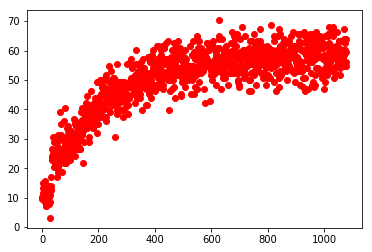

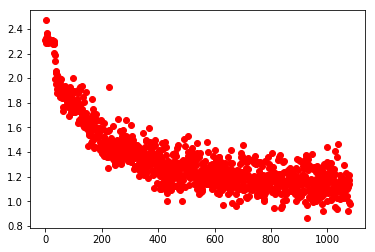

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

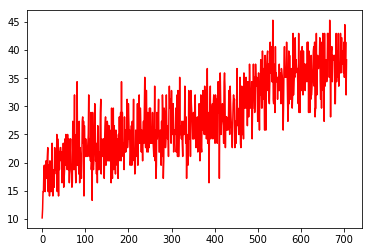

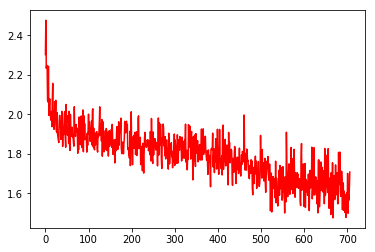

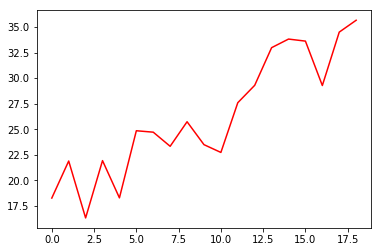

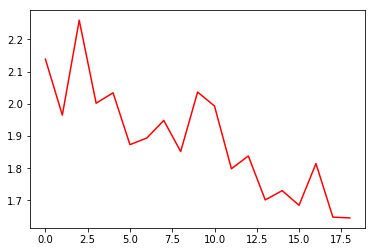

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()